# Community detection to define response profile subtypes on the Conners-3 questionnaire

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import display
from ipywidgets import interact

In [3]:
import bct
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
from numpy import random
from scipy.stats import chisquare, mannwhitneyu, shapiro, ttest_ind
import statsmodels.api as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.formula.api import ols
import seaborn as sns
import pandas as pd

In [4]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 90*mm2inches
double_column = 190*mm2inches
one_half_column = 140*mm2inches

In [5]:
outfolder = '/imaging/jb07/CALM/Behavioural/Community_Detection/'

## Function definitions

In [6]:
## Graph Theory function
def construct_network(df):
    
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from statsmodels.formula.api import ols

    variables = [col for col in df.columns if col not in ['age']]

    # Scaling the variables
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[df.columns]), columns=df.columns)

    # Regressing the effect of age
    df_woAge = df_scaled.copy()
    for variable in variables:
        df_woAge[variable] = ols(variable + ' ~ age', data=df_scaled).fit().resid

    network = df_woAge[variables].transpose().corr().values

    return (network, df_woAge)

def get_consensus_module_assignment(network, iterations):
    #================================
    # Obtain the consensus module structure
    #================================
    """
    inputs:
    adjacency_matrix: adjacency_matrix
    gamma: gamma value

    outputs:
    vector of module assignment for each node
    """
    import numpy as np
    consensus_matrices = list()

    for i in range(0,iterations):
        consensus_matrix,modules,q = get_consensus_matrix(network)
        consensus_matrices.append(consensus_matrix)

    mean_consensus_matrix = np.mean(consensus_matrices,axis=0)

    consensus_matrix,modules,q = get_consensus_matrix(mean_consensus_matrix)
    consensus_matrix2,modules,q = get_consensus_matrix(mean_consensus_matrix)

    while abs(np.sum(consensus_matrix - consensus_matrix2)) != 0:
        consensus_matrix,modules,q = get_consensus_matrix(mean_consensus_matrix)
        consensus_matrix2,modules,q = get_consensus_matrix(mean_consensus_matrix)

    return (modules, q)

def get_consensus_matrix(network):
    import bct
    import numpy as np
    modules,q = bct.modularity_louvain_und_sign(network, qtype='smp')
    module_matrix = np.repeat(modules,repeats=network.shape[0])
    module_matrix = np.reshape(module_matrix,newshape=network.shape)
    consensus_matrix = module_matrix == module_matrix.transpose()
    return (consensus_matrix.astype('float'), modules, q)

def plot_network(network):
    import matplotlib.pyplot as plt

    plt.imshow(network, 
               cmap='jet',
               interpolation='none',
               vmin=-1, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar()
    cb.set_label('Pearson correlation coefficient R')
    cb.ax.yaxis.set_label_position('left')

def plot_community_matrix(network, community_affiliation):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    sorting_array = sorted(range(len(community_affiliation)), key=lambda k: community_affiliation[k])
    sorted_network = network[sorting_array, :]
    sorted_network = sorted_network[:, sorting_array]
    plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=300)
    im = plt.imshow(sorted_network, 
               cmap='jet',
               interpolation='none',
               vmin=-1, vmax=1)
    ax = plt.gca()
    ax.grid('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('Pearson correlation coefficient R')
    cb.ax.yaxis.set_label_position('right')
    plt.tight_layout(pad=0, w_pad=1, h_pad=0)

    
def plot_spring_network(network, community_affiliation):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    
    plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=300)
    G=nx.from_numpy_matrix(bct.threshold_absolute(network, 0.8))
    colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

    pos=nx.spring_layout(G)

    for community in np.unique(community_affiliation):

        nx.draw_networkx_nodes(G,pos,
                               nodelist=np.where(community_affiliation == community)[0].tolist(),
                               node_color=colours[community-1],
                               node_size=20,
                               alpha=0.8)


    nx.draw_networkx_edges(G,pos,width=0.5,alpha=0.5)
    plt.axis('off');
    plt.legend(['C' + str(community) for community in np.unique(community_affiliation) ])
    
def add_noise(network, percentage_noise):
    import numpy as np

    network_wNoise = (1-(float(percentage_noise)/100))*network + (float(percentage_noise)/100)*np.random.normal(0, 1, network.shape)

    return network_wNoise

def get_connection_densities(network, community_affiliation):
    #================================
    # Get density of within and between module connections
    #================================
    """
    inputs:
    network: adjacency_matrix (NumPy array)
    community_affiliation: array that indicates which community/module an node belongs to

    outputs:
    density of connections within modules
    density of connections between modules
    """

    import networkx as nx
    
    network[network > 0] = 1. # binarizing the network
    
    G = nx.from_numpy_matrix(network) # original network
    for node in G.nodes():
         G.node[node]['community'] = community_affiliation[node]

    within_weights = list()
    between_weights = list()

    for edge in G.edges():
        if G.node[edge[0]]['community'] == G.node[edge[1]]['community']:
            within_weights.append(G.edge[edge[0]][edge[1]]['weight'])
        else:
            between_weights.append(G.edge[edge[0]][edge[1]]['weight'])

    connected_G = nx.from_numpy_matrix(np.ones(shape=network.shape)) # fully-connected network
    full_within_weights = list()
    full_between_weights = list()

    for node in connected_G.nodes():
         connected_G.node[node]['community'] = community_affiliation[node]

    for edge in connected_G.edges():
        if connected_G.node[edge[0]]['community'] == connected_G.node[edge[1]]['community']:
            full_within_weights.append(connected_G.edge[edge[0]][edge[1]]['weight'])
        else:
            full_between_weights.append(connected_G.edge[edge[0]][edge[1]]['weight'])

    within_density = sum(within_weights)/sum(full_within_weights)
    between_density = sum(between_weights)/sum(full_between_weights)
    
    return(within_density, between_density)

def make_SuePlot(df, measures, labels, width, name):
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})
    colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

    plt.figure(figsize=(width, double_column/2), dpi=600)

    plt.subplot(2,1,1)
    for community in np.unique(df['groups'].values):
        plt.errorbar(x=range(0,len(measures)),
                y=df[df['groups'] == community].mean().values[1:],
                yerr=2*df[df['groups'] == community].std().values[1:]/sqrt(len(df[df['groups'] == community])),
                color=colours[community-1])

    plt.xlim([-0.5,len(measures)-0.5])
    plt.xticks(range(0,len(measures)))
    plt.legend(['C' + str(community) for community in np.unique(community_affiliation) ], frameon=True, loc='best')
    plt.ylabel('z-score residuals')
    ax = plt.gca()
    ax.set_xticklabels('', rotation=90);
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.subplot(2,1,2)
    combinations = list(itertools.combinations(np.unique(community_affiliation), 2))

    new_style = {'grid': False}
    matplotlib.rc('axes', **new_style)
    plt.imshow(binarized_results, 
              interpolation = 'none', 
              cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'lightgray'), (1, 'orangered')]))
    plt.yticks(np.arange(0,len(combinations)))
    plt.xticks(np.arange(0, len(measures)))
    plt.ylabel('contrast results')

    ax = plt.gca()
    ax.set_yticklabels([str(combination[0]) + ' v ' + str(combination[1]) for combination in combinations], rotation=0);
    ax.set_xticklabels(labels, rotation=90);
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(outfolder + 'Sue_plot' + name + '.png', dpi=300)

### Loading the data

In [7]:
df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')
print('Number of children assessed: ' + str(len(df['ID'])))

Number of children assessed: 390


In [8]:
df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')
df = df[['ID','Gender', 'Age_in_months', 
        'Conners_inattention_raw',
        'Conners_hyperactivity_impulsivity_raw',
        'Conners_learning_problems_raw',
        'Conners_ExecutiveFunction_raw',
        'Conners_agression_raw',
        'Conners_PeerRelations_raw',
        'Conners_Positive_Impression',
        'Connors_Negative_Impression']]

df.columns = ['ID', 'gender', 'age',
              'Inattention',
              'HyperactImpuls',
              'LearnProb',
              'ExeFunc',
              'Aggression',
              'PeerRel',
              'PosImp',
              'NegImp']

#### Forcing numeric variables to numeric format

In [9]:
variables = df.columns[2:].values

for variable in variables: 
    df[variable] = df[variable].astype(str).convert_objects(convert_numeric=True)

/home/jb07/python_modules/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


#### Removing missing values

In [10]:
df = df.replace(999,float('nan'))
df = df.replace('incomplete',float('nan'))
df = df.replace('INCOMPLETE',float('nan'))
df = df.replace('.',float('nan'))
df = df.dropna()
print('Number of children with complete data on Conners-3: ' + str(len(df['ID'])))

Number of children with complete data on Conners-3: 357


Assessing validity scales

In [11]:
print('Possibly overly positive response style: ' + str(sum(df['PosImp'].values > 3)))
print('Possibly overly positive response style: ' + str(sum(df['NegImp'].values > 3)))

Possibly overly positive response style: 0
Possibly overly positive response style: 61


In [12]:
network,df_woAge = construct_network(df[['age', 'Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']])
df_woAge['ID']  = df['ID']
df_woAge['gender'] = df['gender']

In [13]:
print('Number of children included in the analysis: ' + str(len(df)) + 
      ' (M:' + str(len(df_woAge[df_woAge['gender'] == 'male'])) + 
      '; F:' + str(len(df_woAge[df_woAge['gender'] == 'female'])) + ')')

print('Age: mean=' + 
    str(round(df['age'].mean(), 2)) + 
    '; SE=' +
    str(round(df['age'].std()/sqrt(len(df['age'])), 3)) + 
    '; Range=' + 
    str(round(df['age'].min(), 2)) + '-' +
    str(round(df['age'].max(), 2)))

Number of children included in the analysis: 357 (M:222; F:116)
Age: mean=115.35; SE=3.86; Range=63.0-1394.0


#### Community detection to define subgroups

In [14]:
community_affiliation,q = get_consensus_module_assignment(network, 100)

In [15]:
print('Quality index:' + str(round(q,2)))

Quality index:0.65


In [16]:
df['groups'] = community_affiliation
df.to_csv(outfolder + '/Behavioural_data_grouped_Jan17.csv')

##### Plotting the results

/home/jb07/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


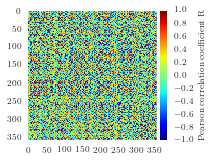

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(one_half_column/2, one_half_column/2), dpi=300)
im = plt.imshow(network, 
           cmap='jet',
           interpolation='none',
           vmin=-1, vmax=1)
ax = plt.gca()
ax.grid('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('Pearson correlation coefficient R')
cb.ax.yaxis.set_label_position('right')
plt.tight_layout(pad=0, w_pad=1, h_pad=0)
plt.savefig(outfolder + 'native_matrix.png', dpi=300)

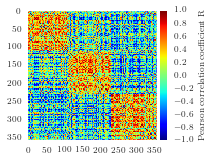

In [18]:
plot_community_matrix(network, community_affiliation)
plt.savefig(outfolder + 'community_matrix.png', dpi=300)

**Figure**: Adjacency matrix after ordering nodes according to the community assignment. The adjacency matrix shows a clear separation of communities as indicated by the distinct rectangles along the diagonal. 

/home/jb07/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


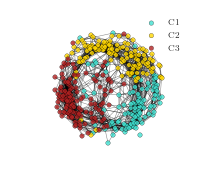

In [19]:
plot_spring_network(network, community_affiliation)
plt.savefig(outfolder + 'spring_layout.png', dpi=300)

**Figure**: Visualization of community detection. The figure shows the three communities detected by the algorithm. The network is plotted in a spring layout and was thresholded at 0.6 for visualization purposes.

### Stats

Getting descriptives for the group assignment

In [20]:
df_woAge['groups'] = community_affiliation

In [21]:
print('Cluster 1: ' + str(len(df_woAge[df_woAge['groups'] == 1])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 1]))/len(df_woAge), 2)) + '%)')
print('Cluster 2: ' + str(len(df_woAge[df_woAge['groups'] == 2])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 2]))/len(df_woAge), 2)) + '%)')
print('Cluster 3: ' + str(len(df_woAge[df_woAge['groups'] == 3])) + '(' + str(round(100*float(len(df_woAge[df_woAge['groups'] == 3]))/len(df_woAge), 2)) + '%)')

Cluster 1: 110(30.81%)
Cluster 2: 121(33.89%)
Cluster 3: 126(35.29%)


In [22]:
print('Connection density within modules: ' + str(round(get_connection_densities(network, community_affiliation)[0], 2)))
print('Connection density outside modules: ' + str(round(get_connection_densities(network, community_affiliation)[1], 2)))

Connection density within modules: 0.79
Connection density outside modules: 0.05


Checking the distribution of scores in each group

In [23]:
for variable in variables[1:-2]:
    print(variable + ': p=' + str(round(shapiro(df_woAge[df_woAge['groups'] == 1][variable])[1], 3)))

Inattention: p=0.0
HyperactImpuls: p=0.0
LearnProb: p=0.022
ExeFunc: p=0.0
Aggression: p=0.0
PeerRel: p=0.0


Creating a data frame with the data in long format for plotting and statistics 

In [24]:
df_woAge['groups'] = community_affiliation
df_long = pd.melt(df_woAge, id_vars=['ID','age', 'gender', 'groups'])
df_long['variable'] = pd.Categorical(df_long['variable'].values, categories=df_woAge.columns[1:-3].values, ordered=True)

Contrasts with Mann-WhitneyU and Bonferroni correction:

In [25]:
combinations = list(itertools.combinations(np.unique(community_affiliation), 2))
corrected_results = [np.asarray([round(mannwhitneyu(df_woAge[df_woAge['groups'] == combinations[i][0]][variable], df_woAge[df_woAge['groups'] == combinations[i][1]][variable])[1]*len(combinations)*len(df_woAge.columns[1:-3]), 3) for variable in df_woAge.columns[1:-3]]) for i in range(0,len(combinations))]
stat_results = [np.asarray([round(mannwhitneyu(df_woAge[df_woAge['groups'] == combinations[i][0]][variable], df_woAge[df_woAge['groups'] == combinations[i][1]][variable])[0], 0) for variable in df_woAge.columns[1:-3]]) for i in range(0,len(combinations))]

In [26]:
results = pd.DataFrame()
results['median1'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,0]
results['mad1'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,0]
results['median1'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,1]
results['mad2'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,1]
results['median1'] = df_woAge.groupby('groups').median().round(2)[variables[1:-2]].transpose().values[:,2]
results['mad3'] = df_woAge.groupby('groups').mad().round(3)[variables[1:-2]].transpose().values[:,2]
results['U1'] = stat_results[0]
results['p1'] = corrected_results[0]
results['U2'] = stat_results[1]
results['p2'] = corrected_results[1]
results['U3'] = stat_results[2]
results['p3'] = corrected_results[2]
print(results.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  median1 &   mad1 &   mad2 &   mad3 &    U1 &     p1 &    U2 &     p2 &    U3 &     p3 \\
\midrule
0 &     0.02 &  0.425 &  0.816 &  0.936 &  2967 &  0.000 &  4181 &  0.000 &  6794 &  1.260 \\
1 &     0.57 &  0.657 &  0.609 &  0.871 &  2183 &  0.000 &  6740 &  6.455 &  3511 &  0.000 \\
2 &    -0.75 &  0.685 &  0.593 &  0.867 &  3590 &  0.000 &  4651 &  0.000 &  2685 &  0.000 \\
3 &     0.00 &  0.600 &  0.843 &  0.937 &  3966 &  0.000 &  5122 &  0.005 &  6818 &  1.366 \\
4 &     0.35 &  0.453 &  0.532 &  1.059 &  6493 &  6.745 &  3710 &  0.000 &  4015 &  0.000 \\
5 &     0.67 &  0.538 &  0.689 &  0.987 &  5654 &  0.436 &  3564 &  0.000 &  4755 &  0.000 \\
\bottomrule
\end{tabular}



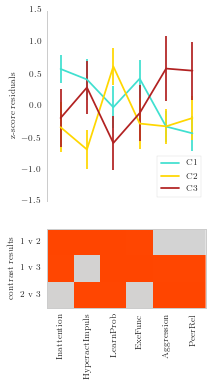

In [27]:
binarized_results = np.vstack([corrected_results < 0.05 for corrected_results in corrected_results])

sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

plt.figure(figsize=(one_half_column/2, one_half_column), dpi=300)

plt.subplot(2,1,1)
for community in np.unique(community_affiliation):
    plt.errorbar(x=range(0,len(df_woAge.columns[1:-3].values)),
                 y=df_long.groupby(['variable','groups']).mean().values[community-1::len(np.unique(community_affiliation)),2],
                yerr=(df_long.groupby(['variable','groups']).std().values[community-1::len(np.unique(community_affiliation)),2]/np.sqrt(len(df_long.groupby(['variable','groups']).sum().values[community-1::len(np.unique(community_affiliation)),1]))),
                color=colours[community-1])

plt.xlim([-0.5,len(df_woAge.columns[1:-3].values)-0.5])
plt.xticks(range(0,len(df_woAge.columns[1:-3].values)))
plt.legend(['C' + str(community) for community in np.unique(community_affiliation) ], frameon=True, loc='best')
plt.ylabel('z-score residuals')
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.subplot(2,1,2)
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
plt.imshow(binarized_results, 
          interpolation = 'none', 
          cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'lightgray'), (1, 'orangered')]))
plt.yticks(np.arange(0,len(combinations)))
plt.xticks(np.arange(0, len(np.unique(df_long['variable'].values))))
plt.ylabel('contrast results')

ax = plt.gca()
ax.set_yticklabels([str(combination[0]) + ' v ' + str(combination[1]) for combination in combinations], rotation=0);
ax.set_xticklabels(df_woAge.columns[1:-2].values, rotation=90);
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(outfolder + 'Sue_plot.png', dpi=300)

### Robustness testing
Here, the robustness of the community assignment is tested by adding increasing amounts of random Gaussian noise to the network matrix.

In [231]:
quality_indices = list()
max_percent = 100

for percentage in np.arange(0,max_percent,5):
    network_wNoise = add_noise(network, percentage)
    try:
        community_affiliation,q = get_consensus_module_assignment(network_wNoise, 100)
        quality_indices.append(q)
    except:
        quality_indices.append(float('nan'))

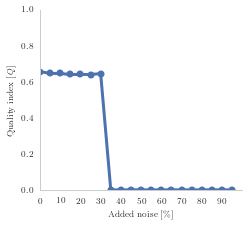

In [232]:
plt.figure(figsize=(single_column, 82*mm2inches), dpi=300)
plt.plot(np.arange(0,max_percent,5), np.nan_to_num(quality_indices), '-o', linewidth=3)
plt.xticks(np.arange(0,max_percent,10))
plt.xlabel('Added noise [\%]')
plt.ylim([0,1])
plt.ylabel(r'Quality index [\textit{Q}]')
ax = plt.gca()
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout(pad=1, w_pad=0, h_pad=0)
plt.savefig('/imaging/jb07/CALM/Behavioural/Community_Detection/Added_noise.png', dpi=300)

## Comparing severities on standardised scores

The grouping in the community detection analysis was based on raw scores after regressing age. In order to determine if the groups are within clinical ranges according to the normative data of the questionnaire, the groups are compared on their T scores here

In [20]:
network,df_woAge = construct_network(df[['age', 'Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']])
df_woAge['ID']  = df['ID']
df_woAge['gender'] = df['gender']
community_affiliation,q = get_consensus_module_assignment(network, 100)
df_woAge['groups'] = community_affiliation

std_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')
std_df = std_df[['ID',
        'Conners_inattention_T',
        'Conners_hyperactivity_impulsivity_T',
        'Conners_learning_problems_T',
        'Conners_ExecutiveFunction_T',
        'Conners_agression_T',
        'Conners_PeerRelations_T']]

std_df.columns = ['ID',
              'Inattention_T',
              'HyperactImpuls_T',
              'LearnProb_T',
              'ExeFunc_T',
              'Aggression_T',
              'PeerRel_T']

std_df = pd.merge(df_woAge, std_df, on='ID')
std_df = std_df[['ID', 'groups', 'Inattention_T', 'HyperactImpuls_T', 'LearnProb_T', 'ExeFunc_T', 'Aggression_T', 'PeerRel_T']]
std_df = std_df.replace({r"[>=<]":90}, regex=True)

variables = std_df.columns[2:].values
for variable in variables: 
    std_df[variable] = std_df[variable].astype(str).convert_objects(convert_numeric=True)

/home/jb07/python_modules/ipykernel/__main__.py:30: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [21]:
df_long = pd.melt(std_df, id_vars=['ID', 'groups'])
df_long['variable'] = pd.Categorical(df_long['variable'].values, categories=std_df.columns[2:].values, ordered=True)

/home/jb07/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


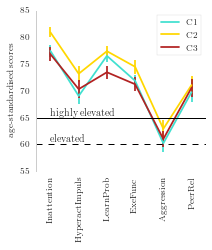

In [22]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

plt.figure(figsize=(one_half_column/2, one_half_column), dpi=300)

plt.subplot(2,1,1)
for community in np.unique(community_affiliation):
    plt.errorbar(x=range(0,len(std_df.columns[2:].values)),
                 y=std_df[std_df['groups'] == community].mean()[2:].values,
                 yerr=std_df[std_df['groups'] == community].std()[2:].values/sqrt(len(std_df[std_df['groups'] == 1])),
                 color=colours[community-1])

plt.legend(['C' + str(community) for community in np.unique(community_affiliation) ], frameon=True, loc='best')

plt.axhline(y=65, linewidth=1, color='k', linestyle='solid')
plt.axhline(y=60, linewidth=1, color='k', linestyle='dashed')
plt.xlim([-0.5,len(df_woAge.columns[1:-3].values)-0.5])
plt.xticks(range(0,len(df_woAge.columns[1:-3].values)))
plt.text(0, 65.5, 'highly elevated')
plt.text(0, 60.5, 'elevated')
plt.ylabel('age-standardised scores')
ax = plt.gca()
ax.set_xticklabels('', rotation=90);
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticklabels(df_woAge.columns[1:-2].values, rotation=90);
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

In [42]:
scales = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']

for scale in scales:
    mean = np.mean(std_df[scale + '_T'].values)
    std = np.std(std_df[scale + '_T'].values)
    number_elevated = np.sum(1*(std_df[scale + '_T'] > 60))
    percent_elevated = 100*(float(number_elevated))/len(std_df[scale + '_T'])
    
    print(scale)
    #print('mean=%.2f, std=%.3f' % (mean, std))
    print('Proportion: %.i (%.i)' % (number_elevated, percent_elevated))

Inattention
Proportion: 297 (87)
HyperactImpuls
Proportion: 224 (66)
LearnProb
Proportion: 294 (86)
ExeFunc
Proportion: 266 (78)
Aggression
Proportion: 144 (42)
PeerRel
Proportion: 209 (61)


## Comparing the groups on other questionnaires 

### SDQ

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
SDQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']]

merged_df = pd.merge(group_df, SDQ_df, on='ID').dropna()
SDQ_measures = ['SDQ_emotion', 'SDQ_conduct', 'SDQ_Hyperactivity', 'SDQ_Peerproblems', 'SDQ_prosocial']
merged_df[SDQ_measures] = scaler.fit_transform(merged_df[SDQ_measures])

In [32]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]

for SDQ_measure in SDQ_measures:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(merged_df[merged_df['groups'] == group_comparison[0]][SDQ_measure].values.astype('int'), merged_df[merged_df['groups'] == group_comparison[1]][SDQ_measure].values.astype('int'))
        results.set_value(SDQ_measure, str(group_comparison), p)

In [33]:
results

,"(1, 2)","(1, 3)","(2, 3)"
SDQ_emotion,5.477473e-02,5.396716e-01,1.683231e-01
SDQ_conduct,1.100461e-03,3.438683e-09,1.997332e-04
SDQ_Hyperactivity,2.113826e-02,3.199205e-06,1.414936e-16
SDQ_Peerproblems,1.761562e-08,6.159390e-05,7.541747e-02
SDQ_prosocial,1.488869e-02,9.160537e-05,1.299824e-01


In [37]:
rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

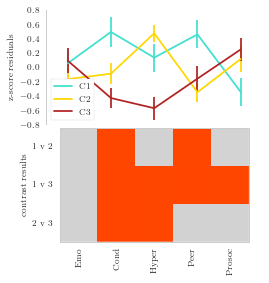

In [38]:
df = merged_df[np.hstack(['groups', SDQ_measures])]
labels = ['Emo', 'Cond', 'Hyper', 'Peer', 'Prosoc']
make_SuePlot(df, SDQ_measures, labels, single_column, 'SDQ')

### BRIEF

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
BRIEF_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']]

merged_df = pd.merge(group_df, BRIEF_df, on='ID').dropna()
BRIEF_measures = ['Brief_Inhibit_raw', 'Brief_Shift_raw', 'Brief_Emotional_Control_raw', 'Brief_Initiate_raw', 'Brief_Working_Memory_raw', 'Brief_Planning_raw', 'Brief_Organisation_raw', 'Brief_Monitor_raw']
merged_df[BRIEF_measures] = scaler.fit_transform(merged_df[BRIEF_measures])

In [40]:
results = pd.DataFrame()
group_comparisons = [(1,2), (1,3), (2,3)]

for BRIEF_measure in BRIEF_measures:
    for group_comparison in group_comparisons:
        t,p = ttest_ind(merged_df[merged_df['groups'] == group_comparison[0]][BRIEF_measure].values.astype('int'), merged_df[merged_df['groups'] == group_comparison[1]][BRIEF_measure].values.astype('int'))
        results.set_value(BRIEF_measure, str(group_comparison), p)

In [41]:
results

,"(1, 2)","(1, 3)","(2, 3)"
Brief_Inhibit_raw,0.130197,7.297262e-09,0.000003
Brief_Shift_raw,0.035655,1.806073e-02,0.842705
Brief_Emotional_Control_raw,0.001116,8.809389e-06,0.221073
Brief_Initiate_raw,0.585704,1.552493e-01,0.289084
Brief_Working_Memory_raw,0.000106,2.737064e-01,0.000975
Brief_Planning_raw,0.132261,3.676987e-01,0.008165
Brief_Organisation_raw,0.017534,4.702048e-02,0.000003
Brief_Monitor_raw,0.853976,1.386454e-03,0.000287


In [42]:
rej, p, alphaSidak, alphaBonferroni = multipletests(results.values.flatten(), alpha=0.05, method='bonferroni')
binarized_results = 1*(results.values < alphaBonferroni).transpose()

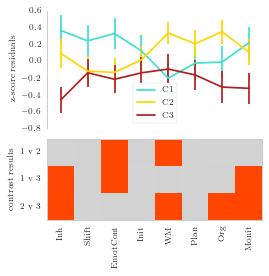

In [43]:
df = merged_df[np.hstack(['groups', BRIEF_measures])]
labels = ['Inh', 'Shift', 'EmotCont', 'Init', 'WM', 'Plan', 'Org', 'Monit']
make_SuePlot(df, BRIEF_measures, labels, single_column, 'BRIEF')

## Characterising learning problems in the whole sample

In [99]:
group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
WIAT_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'WIAT_Spelling_std', 'WIAT_Reading_Std', 'WIAT_Numerical_Std']]

merged_df = pd.merge(group_df, WIAT_df, on='ID').dropna()
WIAT_measures = ['WIAT_Spelling_std', 'WIAT_Reading_Std', 'WIAT_Numerical_Std']

In [106]:
for measure in WIAT_measures:
    print(measure)
    total = np.sum(1*(merged_df[measure] < 90))
    percentage = float(np.sum(1*(merged_df[measure] < 90)))/len(merged_df[measure])
    print('Low range= %.2f (%.2f)' % (total, percentage))
    print('\n')

WIAT_Spelling_std
Low range= 207.00 (0.73)


WIAT_Reading_Std
Low range= 175.00 (0.61)


WIAT_Numerical_Std
Low range= 203.00 (0.71)




## Characterising performance IQ in the whole sample

In [108]:
group_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
IQ_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')[['ID', 'Matrix_Reasoning_T']]

merged_df = pd.merge(group_df, IQ_df, on='ID').dropna()

In [112]:
mean = np.mean(merged_df['Matrix_Reasoning_T'])
std = np.std(merged_df['Matrix_Reasoning_T'])
print('Matrix Reasoning: mean=%.2f, std=%.3f' % (mean, std))

Matrix Reasoning: mean=42.98, std=9.412


In [119]:
total = np.sum(1*(merged_df['Matrix_Reasoning_T'] < 40))
percentage = float(total)/len(merged_df['Matrix_Reasoning_T'])
print('Low range= %.2f (%.2f)' % (total, percentage))

Low range= 136.00 (0.39)


## Comparing diagnoses between groups

In [54]:
diag_df = pd.read_csv(outfolder + 'CALM_behavioural_data_Jul16.csv')
diag_df = diag_df[['ID','Diagnosis']]
diag_df = pd.merge(df_woAge, diag_df, on='ID')

In [102]:
diagnostic_label = list()

for entry in diag_df['Diagnosis'].values:
    if entry in ('1', '2', '3', '22', '26', '27', '27', '28', '29', '30', '31', '34', '35'):
        diagnostic_label.append('ADD/ADHD')
    elif entry in ('4','6', '21'):
        diagnostic_label.append('Anxiety/Depression')
    elif entry in ('7', '8', '9', '10', '11', '12', '13', '14', '15'):
        diagnostic_label.append('Learning Deficit')
    elif entry in ('24','25','24','23','20'):
        diagnostic_label.append('ASD')
    elif entry in ('3', '32'):
        diagnostic_label.append('OCD')
    elif entry in (float(nan), '0'):
        diagnostic_label.append('None')
    else:
        diagnostic_label.append('Other')

diag_df['Label'] = diagnostic_label

In [103]:
diagnosis_breakdown = pd.DataFrame(diag_df['Label'].value_counts())
diagnosis_breakdown['Percentage'] = 100*(diagnosis_breakdown['Label'].values.astype('float')/390)

In [104]:
diagnosis_breakdown

,Label,Percentage
None,247,63.333333
ADD/ADHD,36,9.230769
Learning Deficit,26,6.666667
ASD,14,3.589744
Other,14,3.589744
Anxiety/Depression,1,0.256410


### Comparing frequency of diagnoses between groups

In [166]:
group_counts = np.asarray(diag_df.groupby('groups')['Label'].value_counts().tolist())

In [240]:
for i in np.arange(0, len(np.unique(diag_df['Label'].values))-1):
    observed_values = group_counts[np.arange(i, len(group_counts)-1, len(np.unique(diag_df['Label'].values))-1)]
    predicted_values = np.repeat(float(np.sum(observed_values))/len(np.unique(diag_df['groups'].values)), len(np.unique(diag_df['groups'].values)))
    chisq, p = chisquare(observed_values, predicted_values)
    print(np.unique(diag_df['Label'])[i])
    print('$X^2$(%i,%i)=%.2f, $p$=%.3f' % (len(np.unique(diag_df['groups'])), 354, chisq, p))

ADD/ADHD
$X^2$(3,354)=1.08, $p$=0.584
ASD
$X^2$(3,354)=2.67, $p$=0.264
Anxiety/Depression
$X^2$(3,354)=0.54, $p$=0.764
Learning Deficit
$X^2$(3,354)=1.62, $p$=0.444
None
$X^2$(3,354)=0.50, $p$=0.779


In [235]:
len(diag_df['groups'])

338

In [243]:
afile = np.loadtxt('/imaging/jb07/ZDHHC9/connectome_revisions/connectome/_subject_id_c1/_model_CSA/_threshold_0/calc_matrix/mapflow/_calc_matrix0/c1_dwi_CSA_0_matrix.txt')

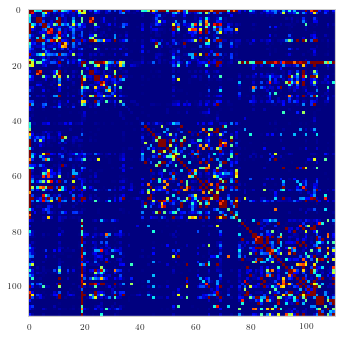

In [248]:
plt.imshow(afile, interpolation='none', cmap='jet', vmax=100)